# Moon Data Classification

In this notebook, you'll be tasked with building and deploying a **custom model** in SageMaker. Specifically, you'll define and train a custom, PyTorch neural network to create a binary classifier for data that is separated into two classes; the data looks like two moon shapes when it is displayed, and is often referred to as **moon data**.

The notebook will be broken down into a few steps:
* Generating the moon data
* Loading it into an S3 bucket
* Defining a PyTorch binary classifier
* Completing a training script
* Training and deploying the custom model
* Evaluating its performance

Being able to train and deploy custom models is a really useful skill to have. Especially in applications that may not be easily solved by traditional algorithms like a LinearLearner.

---

Load in required libraries, below.

In [24]:
# data 
import pandas as pd 
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

In [25]:
%matplotlib inline

## Generating Moon Data

Below, I have written code to generate some moon data, using sklearn's [make_moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) and [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

I'm specifying the number of data points and a noise parameter to use for generation. Then, displaying the resulting data.

In [26]:
# set data params
np.random.seed(0)

num_pts = 600
noise_val = 0.25

# generate data
# X = 2D points, Y = class labels (0 or 1)
X, Y = make_moons(num_pts, noise=noise_val)

# Split into test and training data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
    test_size=0.25, random_state=1)

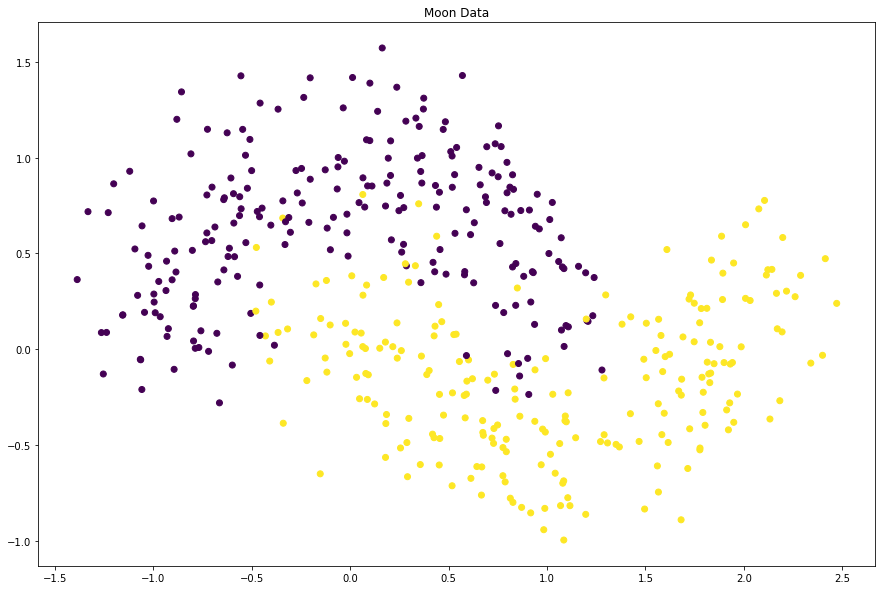

In [27]:
# plot
# points are colored by class, Y_train
# 0 labels = purple, 1 = yellow
plt.figure(figsize=(15,10))
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train)
plt.title('Moon Data')
plt.show()

In [28]:
print(Y_train[:])
Y_train.shape
X.shape

[0 1 1 0 1 0 0 0 1 1 1 1 1 1 0 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0
 1 1 1 0 1 1 0 1 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 0 0 1 1 1 1 1 0 1 0 0
 1 0 1 1 1 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 0 1 0 1 1 1 1 1 1 0 1 0 0 1 1 0
 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 1 1 1 0 1 0 0 1 0 1 1 1 0 0
 1 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1
 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 1 1 1 1 0 1 1 0 0 1 1 0 0 1 0 1 0 0 0 0
 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1
 0 1 1 1 1 0 1 1 1 0 1 1 0 0 0 1 1 0 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0 1 0 1 1
 1 1 1 0 0 1 0 0 0 0 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 0 1 1 0 0 0 0 0 1 0 0 1
 1 0 1 1 1 1 0 1 0 1 0 1 0 0 1 1 0 0 0 1 1 1 1 1 0 1 0 0 1 0 1 0 1 1 0 0 1
 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 0
 0 1 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 1 0 1 0 0 0 0 1 0 1 0 0 1 0 1 0 0 1
 1 1 1 0 1 1]


(600, 2)

## SageMaker Resources

The below cell stores the SageMaker session and role (for creating estimators and models), and creates a default S3 bucket. After creating this bucket, you can upload any locally stored data to S3.

In [29]:
# sagemaker
import boto3
import sagemaker
from sagemaker import get_execution_role

In [30]:
# SageMaker session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# default S3 bucket
bucket = sagemaker_session.default_bucket()

### EXERCISE: Create csv files

Define a function that takes in x (features) and y (labels) and saves them to one `.csv` file at the path `data_dir/filename`. SageMaker expects `.csv` files to be in a certain format, according to the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-training.html):
> Amazon SageMaker requires that a CSV file doesn't have a header record and that the target variable is in the first column.

It may be useful to use pandas to merge your features and labels into one DataFrame and then convert that into a `.csv` file. When you create a `.csv` file, make sure to set `header=False`, and `index=False` so you don't include anything extraneous, like column names, in the `.csv` file.

In [31]:
import os

def make_csv(x, y, filename, data_dir):
    '''Merges features and labels and converts them into one csv file with labels in the first column.
       :param x: Data features
       :param y: Data labels
       :param file_name: Name of csv file, ex. 'train.csv'
       :param data_dir: The directory where files will be saved
       '''
    # make data dir, if it does not exist
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    # your code here
  # Data_features=pd.DataFrame(data=x, dtype='float32')
   # Data_labels=pd.DataFrame(data=y, dtype='float32')
    
 #   comb=pd.concate(Data_features, Data_labels)
  #  comb.to_csv('train.csv')
    
    # first column is the labels and rest is features 
    Combine=pd.concat([pd.DataFrame(y), pd.DataFrame(x)], axis=1)
    
    Create=Combine.to_csv(os.path.join(data_dir, filename), header=False, index=False)
    
    # nothing is returned, but a print statement indicates that the function has run
    print('Path created: '+str(data_dir)+'/'+str(filename))

Just to test creating and concating numpy and pandas arrays

In [32]:
import numpy as np
b=[[1.1, 2.2,3.3,4.4],[3.8,4.8,6.3,1.3]]
#df = pd(data=b)
d=[[3.8,4.8,6.3,1.3],[3.8,4.8,6.3,1.3]]
#print(np.concatenate((b,d),axis=1))
#dfa = pd(data=d)
#comb=pd.concat(df,dfa)
#print(comb)
#b = np.array([(1.5,2,3), (4,5,6)], dtype = ﬂoat) 
c = np.array([[(1.5,2,3), (4,5,6)], [(3,2,1), (4,5,6)]],dtype = ﬂoat)
print(c)

[[[1.5 2.  3. ]
  [4.  5.  6. ]]

 [[3.  2.  1. ]
  [4.  5.  6. ]]]


In [33]:
arrays = [np.array([1,2,3]), np.array([5,4,3])] 
df5 = pd.DataFrame(np.random.rand(3, 2), index=arrays)
print(df5)
df6=pd.array(data=[1,2,3,4] )
print(df6)

            0         1
1 5  0.852736  0.350202
2 4  0.267989  0.061889
3 3  0.821303  0.379666
<PandasArray>
[1, 2, 3, 4]
Length: 4, dtype: int64


The next cell runs the above function to create a `train.csv` file in a specified directory.

In [34]:
data_dir = 'data_moon' # the folder we will use for storing data
name = 'train.csv'

# create 'train.csv'
make_csv(X_train, Y_train, name, data_dir)

Path created: data_moon/train.csv


### Upload Data to S3

Upload locally-stored `train.csv` file to S3 by using `sagemaker_session.upload_data`. This function needs to know: where the data is saved locally, and where to upload in S3 (a bucket and prefix).

In [35]:
# specify where to upload in S3
prefix = 'sagemaker/moon-data'

# upload to S3
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)
print(input_data)

s3://sagemaker-ap-southeast-1-505762439728/sagemaker/moon-data


Check that you've uploaded the data, by printing the contents of the default bucket.

In [36]:
# iterate through S3 objects and print contents
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
     print(obj.key)

counties/kmeans-2020-03-31-16-29-28-357/output/model.tar.gz
counties/kmeans-2020-04-01-15-52-54-731/output/model.tar.gz
counties/pca-2020-02-23-16-26-38-396/output/model.tar.gz
counties/pca-2020-02-24-16-53-41-158/output/model.tar.gz
counties/pca-2020-03-28-10-00-27-306/output/model.tar.gz
counties/pca-2020-04-01-15-40-57-105/output/model.tar.gz
creditcard/linear-learner-2020-04-04-17-00-39-856/output/model.tar.gz
creditcard/linear-learner-2020-04-04-18-01-18-684/output/model.tar.gz
creditcard/linear-learner-2020-04-04-18-23-57-975/output/model.tar.gz
linear-learner-2020-04-04-14-45-55-693/output/model.tar.gz
linear-learner-2020-04-04-15-24-40-403/output/model.tar.gz
moon-data/sagemaker-pytorch-2020-04-12-14-54-08-408/debug-output/training_job_end.ts
moon-data/sagemaker-pytorch-2020-04-12-14-54-08-408/output/model.tar.gz
moon-data/train.csv
sagemaker-pytorch-2020-01-03-10-01-29-916/source/sourcedir.tar.gz
sagemaker-pytorch-2020-01-04-16-29-34-302/source/sourcedir.tar.gz
sagemaker-pytor

---
# Modeling

Now that you've uploaded your training data, it's time to define and train a model!

In this notebook, you'll define and train a **custom PyTorch model**; a neural network that performs binary classification. 

### EXERCISE: Define a model in  `model.py`

To implement a custom classifier, the first thing you'll do is define a neural network. You've been give some starting code in the directory `source`, where you can find the file, `model.py`. You'll need to complete the class `SimpleNet`; specifying the layers of the neural network and its feedforward behavior. It may be helpful to review the [code for a 3-layer MLP](https://github.com/udacity/deep-learning-v2-pytorch/blob/master/convolutional-neural-networks/mnist-mlp/mnist_mlp_solution.ipynb).

This model should be designed to: 
* Accept a number of `input_dim` features
* Create some linear, hidden layers of a desired size
* Return **a single output value** that indicates the class score

The returned output value should be a [sigmoid-activated](https://pytorch.org/docs/stable/nn.html#sigmoid) class score; a value between 0-1 that can be rounded to get a predicted, class label.

Below, you can use !pygmentize to display the code in the `model.py` file. Read through the code; all of your tasks are marked with TODO comments. You should navigate to the file, and complete the tasks to define a `SimpleNet`.

In [37]:
!pygmentize source/model.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Complete this classifier
class SimpleNet(nn.Module):
    
    ## TODO: Define the init function
    def __init__(self, input_dim, hidden_dim, output_dim):
        '''Defines layers of a neural network.
           :param input_dim: Number of input features
           :param hidden_dim: Size of hidden layer(s)
           :param output_dim: Number of outputs
         '''
        super(SimpleNet, self).__init__()

        # linear layer (input_dim -> hidden_dim)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # linear layer (hidden_dim -> output_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)
        # sigmoid layer
        self.sig = nn.Sigmoid()
    
    ## TODO: Define the feedforward behavior of the network
    def forward(self, x):
        '''Feedforward behavior of the n

## Training Script

To implement a custom classifier, you'll also need to complete a `train.py` script. You can find this in the `source` directory.

A typical training script:

* Loads training data from a specified directory
* Parses any training & model hyperparameters (ex. nodes in a neural network, training epochs, etc.)
* Instantiates a model of your design, with any specified hyperparams
* Trains that model
* Finally, saves the model so that it can be hosted/deployed, later

### EXERCISE: Complete the `train.py` script

Much of the training script code is provided for you. Almost all of your work will be done in the if __name__ == '__main__': section. To complete the `train.py` file, you will:

* Define any additional model training hyperparameters using `parser.add_argument`
* Define a model in the if __name__ == '__main__': section
* Train the model in that same section

Below, you can use !pygmentize to display an existing train.py file. Read through the code; all of your tasks are marked with TODO comments.

In [38]:
!pygmentize source/train.py

from __future__ import print_function # future proof
import argparse
import sys
import os
import json

import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

# import model
from model import SimpleNet


def model_fn(model_dir):
    print("Loading model.")

    # First, load the parameters used to create the model.
    model_info = {}
    model_info_path = os.path.join(model_dir, 'model_info.pth')
    with open(model_info_path, 'rb') as f:
        model_info = torch.load(f)

    print("model_info: {}".format(model_info))

    # Determine the device and construct the model.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleNet(model_info['input_dim'], 
                      model_info['hidden_dim'], 
                      model_info['output_dim'])

    # Load the stored model parameters.
    model_path = os.path.join(model_dir, 'model.pth')
    with open(model_path, 'rb') as f:
     

### EXERCISE: Create a PyTorch Estimator

You've had some practice instantiating built-in models in SageMaker. All estimators require some constructor arguments to be passed in. When a custom model is constructed in SageMaker, an **entry point** must be specified. The entry_point is the training script that will be executed when the model is trained; the `train.py` function you specified above! 

See if you can complete this task, instantiating a PyTorch estimator, using only the [PyTorch estimator documentation](https://sagemaker.readthedocs.io/en/stable/sagemaker.pytorch.html) as a resource. It is suggested that you use the **latest version** of PyTorch as the optional `framework_version` parameter.

#### Instance Types

It is suggested that you use instances that are available in the free tier of usage: `'ml.c4.xlarge'` for training and `'ml.t2.medium'` for deployment.

In [41]:
# import a PyTorch wrapper
from sagemaker.pytorch import PyTorch

# specify an output path
# prefix is specified above
output_path = 's3://{}/{}'.format(bucket, prefix)

# instantiate a pytorch estimator
estimator = PyTorch(entry_point='train.py',
                    source_dir='source', # this should be just "source" for your code
                    role=role,
                    framework_version='1.0',
                    train_instance_count=1,
                    train_instance_type='ml.c4.xlarge',
                    output_path=output_path,
                    sagemaker_session=sagemaker_session,
                    hyperparameters={
                        'input_dim': 2,  # num of features
                        'hidden_dim': 20,
                        'output_dim': 1,
                        'epochs': 80 # could change to higher to see if the losses reduce more
                    })

## Train the Estimator

After instantiating your estimator, train it with a call to `.fit()`. The `train.py` file explicitly loads in `.csv` data, so you do not need to convert the input data to any other format.

In [42]:
%%time 
# train the estimator on S3 training data
estimator.fit({'train': input_data})

2020-04-13 18:00:22 Starting - Starting the training job...
2020-04-13 18:00:52 Starting - Launching requested ML instances......
2020-04-13 18:01:53 Starting - Preparing the instances for training......
2020-04-13 18:02:48 Downloading - Downloading input data
2020-04-13 18:02:48 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-04-13 18:03:03,102 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-04-13 18:03:03,105 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-04-13 18:03:03,117 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-04-13 18:03:06,197 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-04-13 18:03:06,442 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2020-04-13 18:03:06,442


2020-04-13 18:03:19 Uploading - Uploading generated training model
2020-04-13 18:03:19 Completed - Training job completed
Epoch: 40, Loss: 0.5103150606155396
Epoch: 41, Loss: 0.5027596689760685
Epoch: 42, Loss: 0.5161555297672749
Epoch: 43, Loss: 0.4878342039883137
Epoch: 44, Loss: 0.48264360055327415
Epoch: 45, Loss: 0.4764711782336235
Epoch: 46, Loss: 0.48982351273298264
Epoch: 47, Loss: 0.4765740968286991
Epoch: 48, Loss: 0.4897451624274254
Epoch: 49, Loss: 0.4595935046672821
Epoch: 50, Loss: 0.47589369490742683
Epoch: 51, Loss: 0.47583263367414474
Epoch: 52, Loss: 0.4581032022833824
Epoch: 53, Loss: 0.47060925513505936
Epoch: 54, Loss: 0.46086645871400833
Epoch: 55, Loss: 0.46166208013892174
Epoch: 56, Loss: 0.4624098502099514
Epoch: 57, Loss: 0.4592600427567959
Epoch: 58, Loss: 0.45261935144662857
Epoch: 59, Loss: 0.46236448362469673
Epoch: 60, Loss: 0.4538392871618271
Epoch: 61, Loss: 0.44061458483338356
Epoch: 62, Loss: 0.4579356797039509
Epoch: 63, Loss: 0.42852402850985527
Ep

## Create a Trained Model

PyTorch models do not automatically come with `.predict()` functions attached (as many Scikit-learn models do, for example) and you may have noticed that you've been give a `predict.py` file. This file is responsible for loading a trained model and applying it to passed in, numpy data. When you created a PyTorch estimator, you specified where the training script, `train.py` was located. 

> How can we tell a PyTorch model where the `predict.py` file is?

Before you can deploy this custom PyTorch model, you have to take one more step: creating a `PyTorchModel`. In earlier exercises you could see that a call to `.deploy()` created both a **model** and an **endpoint**, but for PyTorch models, these steps have to be separate.

### EXERCISE: Instantiate a `PyTorchModel`

You can create a `PyTorchModel` (different that a PyTorch estimator) from your trained, estimator attributes. This model is responsible for knowing how to execute a specific `predict.py` script. And this model is what you'll deploy to create an endpoint.

#### Model Parameters

To instantiate a `PyTorchModel`, ([documentation, here](https://sagemaker.readthedocs.io/en/stable/sagemaker.pytorch.html#sagemaker.pytorch.model.PyTorchModel)) you pass in the same arguments as your PyTorch estimator, with a few additions/modifications:
* **model_data**: The trained `model.tar.gz` file created by your estimator, which can be accessed as `estimator.model_data`.
* **entry_point**: This time, this is the path to the Python script SageMaker runs for **prediction** rather than training, `predict.py`.


In [43]:
%%time
# importing PyTorchModel
from sagemaker.pytorch import PyTorchModel

# Create a model from the trained estimator data
# And point to the prediction script
model =  PyTorchModel(model_data=estimator.model_data,
                     role = role,
                     framework_version='1.0',
                     entry_point='predict.py',
                     source_dir='source')


CPU times: user 14 ms, sys: 0 ns, total: 14 ms
Wall time: 39.9 ms


### EXERCISE: Deploy the trained model

Deploy your model to create a predictor. We'll use this to make predictions on our test data and evaluate the model.

In [44]:
%%time
# deploy and create a predictor
predictor = model.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

---------------!CPU times: user 373 ms, sys: 23.7 ms, total: 397 ms
Wall time: 7min 32s


---
## Evaluating Your Model

Once your model is deployed, you can see how it performs when applied to the test data.

The provided function below, takes in a deployed predictor, some test features and labels, and returns a dictionary of metrics; calculating false negatives and positives as well as recall, precision, and accuracy.

In [45]:
# code to evaluate the endpoint on test data
# returns a variety of model metrics
def evaluate(predictor, test_features, test_labels, verbose=True):
    """
    Evaluate a model on a test set given the prediction endpoint.  
    Return binary classification metrics.
    :param predictor: A prediction endpoint
    :param test_features: Test features
    :param test_labels: Class labels for test data
    :param verbose: If True, prints a table of all performance metrics
    :return: A dictionary of performance metrics.
    """
    
    # rounding and squeezing array
    test_preds = np.squeeze(np.round(predictor.predict(test_features)))
    
    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(test_labels, test_preds).sum()
    fp = np.logical_and(1-test_labels, test_preds).sum()
    tn = np.logical_and(1-test_labels, 1-test_preds).sum()
    fn = np.logical_and(test_labels, 1-test_preds).sum()
    
    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    
    # print metrics
    if verbose:
        print(pd.crosstab(test_labels, test_preds, rownames=['actuals'], colnames=['predictions']))
        print("\n{:<11} {:.3f}".format('Recall:', recall))
        print("{:<11} {:.3f}".format('Precision:', precision))
        print("{:<11} {:.3f}".format('Accuracy:', accuracy))
        print()
        
    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn, 
            'Precision': precision, 'Recall': recall, 'Accuracy': accuracy}



### Test Results

The cell below runs the `evaluate` function. 

The code assumes that you have a defined `predictor` and `X_test` and `Y_test` from previously-run cells.

In [46]:
# get metrics for custom predictor
metrics = evaluate(predictor, X_test, Y_test, True)

predictions  0.0  1.0
actuals              
0             53   18
1             11   68

Recall:     0.861
Precision:  0.791
Accuracy:   0.807



## Delete the Endpoint

Finally, I've add a convenience function to delete prediction endpoints after we're done with them. And if you're done evaluating the model, you should delete your model endpoint!

In [47]:
# Accepts a predictor endpoint as input
# And deletes the endpoint by name
def delete_endpoint(predictor):
        try:
            boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)
            print('Deleted {}'.format(predictor.endpoint))
        except:
            print('Already deleted: {}'.format(predictor.endpoint))

In [48]:
# delete the predictor endpoint 
delete_endpoint(predictor)

Deleted sagemaker-pytorch-2020-04-13-18-04-46-920


## Final Cleanup!

* Double check that you have deleted all your endpoints.
* I'd also suggest manually deleting your S3 bucket, models, and endpoint configurations directly from your AWS console.

You can find thorough cleanup instructions, [in the documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-cleanup.html).

---
# Conclusion

In this notebook, you saw how to train and deploy a custom, PyTorch model in SageMaker. SageMaker has many built-in models that are useful for common clustering and classification tasks, but it is useful to know how to create custom, deep learning models that are flexible enough to learn from a variety of data.